# Directory settings

In [1]:
# !pip3 install wandb --user
# !pip3 install pytorch_lightning --user
# !pip3 install tokenizers --user
# !pip3 install transformers --user
# !pip3 install sentencepiece --user

In [2]:
# ====================================================
# Directory settings
# ====================================================
import os
import wandb

running_on = 'local'

INPUT_DIR = '../data/' # '/content/drive/MyDrive/data/patent_data/' # '../data/'  # ../input/
OUTPUT_DIR = './'

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# !ls /content/drive/MyDrive/data/patent_data

# CFG

**To change for non debug run**

- deeper_layer_to_train (0)
- model path (../input/deberta-v3-large/deberta-v3-large (for kaggle))
- batch size (16)
- epoch (4)
- num_workers (2 or 4)
- waidb_logger (True)

In [3]:
class CFG:
    wandb=False
    competition='PPPM'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    num_workers=2
    model="microsoft/deberta-v3-large"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=4
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=4
    fc_dropout=0.2
    target_size=1
    max_len=133
    weight_decay=0.01
    gradient_accumulation_steps=4
    max_grad_norm=1000
    seed=42
    deeper_layer_to_train=17
    waidb_logger=False
    val_size=0.1

dict_config = {a: CFG.__dict__[a] for a in CFG.__dict__ if a[:2] != '__'}

In [27]:
train.sector.value_counts()

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: sector, dtype: int64

# Library

In [4]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn import metrics

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

from pytorch_lightning.utilities.types import STEP_OUTPUT
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

%env TOKENIZERS_PARALLELISM=true

torch.__version__: 1.11.0
tokenizers.__version__: 0.12.1
transformers.__version__: 4.20.1
env: TOKENIZERS_PARALLELISM=true


# Utils

In [5]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score

seed_everything(seed=CFG.seed)

Global seed set to 42


42

# Data Loading

In [6]:
train = pd.read_csv(INPUT_DIR + 'us-patent-phrase-to-phrase-matching/train.csv')
test = pd.read_csv(INPUT_DIR + 'us-patent-phrase-to-phrase-matching/test.csv')
submission = pd.read_csv(INPUT_DIR + 'us-patent-phrase-to-phrase-matching/sample_submission.csv')

print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")

display(train.head(2))
display(test.head(2))
display(submission.head(2))

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0


In [7]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir(INPUT_DIR + '/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'{INPUT_DIR}/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR + "cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head(2))
display(test.head(2))

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...


In [8]:
train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']
train['sector'] = train.context.str[0]
test['sector'] = test.context.str[0]
display(train.head(2))
display(test.head(2))

,id,anchor,target,context,score,context_text,text,sector
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...,A
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...,A


,id,anchor,target,context,context_text,text,sector
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...,G
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...,F


In [9]:
# train = train.iloc[:1000]  # DEBUG

In [10]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(train, test_size=CFG.val_size, shuffle=True, random_state=CFG.seed)
df_test = test
df_train.shape, df_val.shape, df_test.shape

((32825, 8), (3648, 8), (36, 7))

## Tokenizer

In [11]:
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
CFG.tokenizer = tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Dataset

In [12]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df, input_col='text', label_col='score'):
        self.cfg = cfg
        self.texts = df[input_col].values
        self.labels = df[label_col].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label


# Model

In [13]:
import pytorch_lightning as pl

def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
         'lr': encoder_lr, 'weight_decay': weight_decay},
        {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
         'lr': encoder_lr, 'weight_decay': 0.0},
        {'params': [p for n, p in model.named_parameters() if "model" not in n],
         'lr': decoder_lr, 'weight_decay': 0.0}
    ]
    return optimizer_parameters

def get_scheduler(cfg, optimizer, num_train_steps):
    if cfg.scheduler == 'linear':
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
        )
    elif cfg.scheduler == 'cosine':
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
        )
    return scheduler


# ====================================================
# Model
# ====================================================
class CustomModel(pl.LightningModule):
    def __init__(self, cfg, num_train_steps, fold:int = -1):
        super().__init__()
        self.cfg = cfg
        self.model_cfg = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        self.model = AutoModel.from_pretrained(cfg.model, config=self.model_cfg)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.model_cfg.hidden_size, cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.model_cfg.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        self.configure_trained_layers(self.cfg.deeper_layer_to_train)
        self.all_t = np.array([])
        self.all_p = np.array([])
        self.num_train_steps = num_train_steps
        self.criterion = nn.BCEWithLogitsLoss(reduction="mean")
        self.str_fold = f'fold({fold})/' if fold != -1 else ''
        self.fold = fold
        
    def configure_trained_layers(self, deeper_layer_to_train, verbose=0):
        if deeper_layer_to_train == -1:
          return
        requires_grad = False
        print(f'deeper_layer_to_train: {deeper_layer_to_train}')
        for param in self.model.named_parameters():
            if f'encoder.layer.{deeper_layer_to_train}' in param[0]:
                requires_grad = True
            param[1].requires_grad = requires_grad
            if verbose == 2 or (verbose == 1 and requires_grad):
                print(f'layer {param[0]} is {"NOT " if requires_grad is False else ""}trained.')

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.model_cfg.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.model_cfg.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        output = self.fc(self.fc_dropout(feature))
        return output
    
    def configure_optimizers(self):
        optimizer_parameters = get_optimizer_params(self, encoder_lr=self.cfg.encoder_lr, decoder_lr=self.cfg.decoder_lr, weight_decay=self.cfg.weight_decay)
        optimizer = AdamW(optimizer_parameters, lr=self.cfg.encoder_lr, eps=self.cfg.eps, betas=self.cfg.betas)
    
        scheduler = get_scheduler(self.cfg, optimizer, self.num_train_steps)
        scheduler = {'scheduler': scheduler, 'interval': 'step', 'frequency': 1}
        
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx) -> STEP_OUTPUT:
        d = self._common_step(batch, batch_idx, 'train')
        return d['loss']
        
    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, 'val')

    def _common_step(self, batch, batch_idx, stage: str):
        inputs, labels = batch
        y_hat = self(inputs)

        loss = self.criterion(y_hat.view(-1, 1), labels.view(-1, 1))

        labels = labels.view(-1).detach().cpu()
        y_hat = y_hat.view(-1).detach().cpu()
        if stage == 'train':
            self.all_t = np.concatenate([self.all_t, labels.numpy()])
            self.all_p = np.concatenate([self.all_p, y_hat.numpy()])
        
        pearson_batch = 1000
        if len(self.all_t) > pearson_batch and stage == 'train':
            self.log(f"{self.str_fold}Pearson_batch{pearson_batch}/{stage}", get_score(self.all_t, self.all_p), on_step=True, prog_bar=True)
            self.all_t = np.array([])
            self.all_p = np.array([])
        
        self._log_metrics(loss, labels, y_hat, stage)
        return {'loss': loss, 'y_true': labels, 'y_pred': y_hat}

    def _log_metrics(self, loss, labels, y_hat, stage: str) -> None:
        y_true = torch.round(labels * 4).to(int).cpu()
        y_hat_cat = torch.min(torch.max(torch.round(y_hat.to(torch.float) * 4).to(int), torch.tensor(0)), torch.tensor(4)).cpu()
        # Compute metrics
        acc = (y_true == y_hat_cat).float().mean()

        # Log metrics
        self.log(f"{self.str_fold}Loss/{stage}", loss, on_step=True, prog_bar=stage == 'train')
        if self.fold != -1:
            self.log(f"Loss/{stage}", loss)
        self.log(f"{self.str_fold}Accuracy/{stage}", acc, on_step=True, prog_bar=stage == 'train')
        self.log(f"fold", self.fold)
        
    def predict_step(self, batch, batch_idx: int, dataloader_idx: int = 0):
        inputs, labels = batch
        y_hat = self(inputs)
        return y_hat.view(-1)

    def validation_epoch_end(self, val_step_outputs):
        y_hat = torch.concat([t['y_pred'] for t in val_step_outputs])
        y_true = torch.concat([t['y_true'] for t in val_step_outputs])
        score = get_score(y_true, y_hat)
        print('score', score)
        self.log('Pearson/val', score)

In [14]:
import gc

# ====================================================
# Callbacks
# ====================================================
lr_logger = LearningRateMonitor(logging_interval='step')
tb_logger = TensorBoardLogger(save_dir="./logs/", name="Deberta_v3_large_finetune_CV")
loggers = [tb_logger]

if CFG.waidb_logger:
    wb_logger = WandbLogger(
        name=f"Deberta_v3_large_finetune_CV",  save_dir='./logs', offline=False, project='PPPM',
        notes="Deberta_v3_large_finetune", tags=["deberta_fine_tune", CFG.model], config=dict_config
    )
    loggers += [wb_logger]

best_models = {}    

def fit_models():
    for sector in df_train.sector.unique():
        df_train_sector = df_train[df_train.sector == sector]
        df_val_sector = df_val[df_val.sector == sector]
        print('Sector', sector, df_train_sector.shape, df_val_sector.shape)

        # ====================================================
        # Training
        # ====================================================
        checkpoint_callback = ModelCheckpoint(
            dirpath='logs', filename='model_'+str(sector)+'-{epoch}', verbose=True, save_top_k=1, mode='max', monitor='Pearson/val',
            auto_insert_metric_name=True
        )
        trainer = pl.Trainer(
            accelerator='gpu', gradient_clip_val=CFG.max_grad_norm, weights_summary="top", max_epochs=CFG.epochs,
            callbacks=[lr_logger, checkpoint_callback], logger=loggers,  accumulate_grad_batches=CFG.gradient_accumulation_steps,
            precision=16, amp_backend="native", gpus=1
        )

        # ====================================================
        # Data Loaders
        # ====================================================
        train_dataset = TrainDataset(CFG, df_train_sector)
        valid_dataset = TrainDataset(CFG, df_val_sector)

        train_loader = DataLoader(
            train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers, pin_memory=True, drop_last=True
        )
        valid_loader = DataLoader(
            valid_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True, drop_last=False
        )
        hparams = dict(cfg=CFG, num_train_steps=int(len(train_loader) * CFG.epochs), fold=-1)
        model = CustomModel(**hparams)

        trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=valid_loader)
        print(f"BEST MODEL PATH", checkpoint_callback.best_model_path)

        # Get best model
        model = CustomModel.load_from_checkpoint(checkpoint_callback.best_model_path, **hparams)

        trainer.validate(model, valid_loader)
        # Predict
        y_hat = trainer.predict(model, valid_loader)
        df_val.loc[(df_val.sector == sector), 'pred'] = np.concatenate(y_hat)
        best_models[sector] = checkpoint_callback.best_model_path

    del model, trainer, train_dataset, valid_dataset, train_loader, valid_loader, checkpoint_callback

    gc.collect()
    torch.cuda.empty_cache()

# fit_models()
#
# with open('./logs/best_models.pkl', 'wb') as f:
#     pickle.dump(best_models, f, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
# print(f'Spearman corr', get_score(df_val.score, df_val.pred))

## Prediction

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


checkpoint /home/cyprien/Documents/github/patent-phrase-matching/notebooks/logs/deberta_ET/model_B-epoch=2.ckpt


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


deeper_layer_to_train: 17


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

checkpoint /home/cyprien/Documents/github/patent-phrase-matching/notebooks/logs/deberta_ET/model_C-epoch=0.ckpt


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


deeper_layer_to_train: 17


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

checkpoint /home/cyprien/Documents/github/patent-phrase-matching/notebooks/logs/deberta_ET/model_E-epoch=0.ckpt


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


deeper_layer_to_train: 17


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

checkpoint /home/cyprien/Documents/github/patent-phrase-matching/notebooks/logs/deberta_ET/model_G-epoch=0.ckpt


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


deeper_layer_to_train: 17


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

checkpoint /home/cyprien/Documents/github/patent-phrase-matching/notebooks/logs/deberta_ET/model_H-epoch=1.ckpt


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


deeper_layer_to_train: 17


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

checkpoint /home/cyprien/Documents/github/patent-phrase-matching/notebooks/logs/deberta_ET/model_F-epoch=0.ckpt


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


deeper_layer_to_train: 17


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

checkpoint /home/cyprien/Documents/github/patent-phrase-matching/notebooks/logs/deberta_ET/model_D-epoch=1.ckpt


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


deeper_layer_to_train: 17


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

checkpoint /home/cyprien/Documents/github/patent-phrase-matching/notebooks/logs/deberta_ET/model_A-epoch=1.ckpt


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


deeper_layer_to_train: 17


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

nan

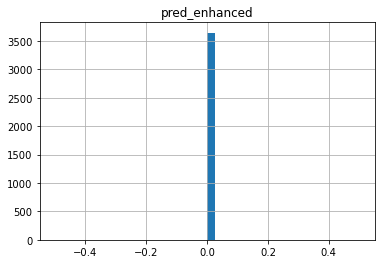

In [20]:
predictor = pl.Trainer(
    accelerator='gpu',
    precision=16,
    amp_backend="native",
    gpus=1
)

df_test['score'] = np.nan
df_test['pred'] = 0

with open('./logs/deberta_ET/best_models.pkl', 'rb') as f:
    best_models = pickle.load(f)

df_val['pred_enhanced_1'] = 0
df_val['pred_enhanced_2'] = 0
df_val['pred_enhanced_3'] = 0
df_val['pred_enhanced_4'] = 0
df_val['pred_enhanced_5'] = 0

for sector in best_models:
    hparams = dict(cfg=CFG, num_train_steps=None, fold=-1)

    test_dataset = TrainDataset(CFG, df_val)
    test_loader = DataLoader(
        test_dataset,
        batch_size=42,
        shuffle=False,
        num_workers=8,
        pin_memory=True,
        drop_last=False
    )

    checkpoint = best_models[sector].replace('logs/', 'logs/deberta_ET/')
    print("checkpoint", checkpoint)

    model = CustomModel.load_from_checkpoint(checkpoint, **hparams)
    y_hat = predictor.predict(model, test_loader)

    # Basic
    df_val['pred_enhanced_1'] += np.concatenate(y_hat) / len(best_models)

    # More weight to main
    df_val['pred_enhanced_2'] += np.concatenate(y_hat) / len(best_models)
    df_val.loc[df_val.sector == sector, 'pred_enhanced_2'] += np.concatenate(y_hat)[df_val.sector == sector] / len(best_models)

    # Even more
    df_val['pred_enhanced_3'] += np.concatenate(y_hat) / len(best_models)
    df_val.loc[df_val.sector == sector, 'pred_enhanced_3'] += np.concatenate(y_hat)[df_val.sector == sector] / len(best_models)
    df_val.loc[df_val.sector == sector, 'pred_enhanced_3'] += np.concatenate(y_hat)[df_val.sector == sector] / len(best_models)

    # Weighted
    df_val['pred_enhanced_4'] += np.concatenate(y_hat) / len(best_models) * (df_train.sector == sector).sum()

    # Weighted + weight to main
    df_val['pred_enhanced_5'] += np.concatenate(y_hat) / len(best_models) * (df_train.sector == sector).sum()
    df_val.loc[df_val.sector == sector, 'pred_enhanced_5'] += np.concatenate(y_hat)[df_val.sector == sector] / len(best_models) * (df_train.sector == sector).sum()



import matplotlib.pyplot as plt

df_val[['pred_enhanced']].hist(bins=40)

get_score(df_val.score, df_val.pred_enhanced) # Basic 0.784070  # advanced 0.7900615

In [22]:
get_score(df_val.score, df_val.pred_enhanced_1), get_score(df_val.score, df_val.pred_enhanced_2), get_score(df_val.score, df_val.pred_enhanced_3), get_score(df_val.score, df_val.pred_enhanced_4), get_score(df_val.score, df_val.pred_enhanced_5)

(0.7840694079060868,
 0.7900615264344355,
 0.7916054385718889,
 0.781004755589928,
 0.7821407095626574)

In [23]:
best_models

{'B': '/home/cyprien/Documents/github/patent-phrase-matching/notebooks/logs/model_B-epoch=2.ckpt',
 'C': '/home/cyprien/Documents/github/patent-phrase-matching/notebooks/logs/model_C-epoch=0.ckpt',
 'E': '/home/cyprien/Documents/github/patent-phrase-matching/notebooks/logs/model_E-epoch=0.ckpt',
 'G': '/home/cyprien/Documents/github/patent-phrase-matching/notebooks/logs/model_G-epoch=0.ckpt',
 'H': '/home/cyprien/Documents/github/patent-phrase-matching/notebooks/logs/model_H-epoch=1.ckpt',
 'F': '/home/cyprien/Documents/github/patent-phrase-matching/notebooks/logs/model_F-epoch=0.ckpt',
 'D': '/home/cyprien/Documents/github/patent-phrase-matching/notebooks/logs/model_D-epoch=1.ckpt',
 'A': '/home/cyprien/Documents/github/patent-phrase-matching/notebooks/logs/model_A-epoch=1.ckpt'}

In [ ]:
best_models = {'B': '../input/pppm-checkpoints-deberta-et/model_B-epoch=2.ckpt',
'C': '../input/pppm-checkpoints-deberta-et/model_C-epoch=0.ckpt',
'E': '../input/pppm-checkpoints-deberta-et/model_E-epoch=0.ckpt',
'G': '../input/pppm-checkpoints-deberta-et/model_G-epoch=0.ckpt',
'H': '../input/pppm-checkpoints-deberta-et/model_H-epoch=1.ckpt',
'F': '../input/pppm-checkpoints-deberta-et/model_F-epoch=0.ckpt',
'D': '../input/pppm-checkpoints-deberta-et/model_D-epoch=1.ckpt',
'A': '../input/pppm-checkpoints-deberta-et/model_A-epoch=1.ckpt'}

In [17]:
predictor = pl.Trainer(
    accelerator='gpu',
    precision=16,
    amp_backend="native",
    gpus=1
)

df_test['score'] = np.nan
df_test['pred'] = 0

with open('./logs/deberta_ET/best_models.pkl', 'rb') as f:
    best_models = pickle.load(f)

for sector in best_models:
    hparams = dict(cfg=CFG, num_train_steps=None, fold=-1)

    test_dataset = TrainDataset(CFG, df_val[df_val.sector == sector])
    test_loader = DataLoader(
        test_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=False
    )

    checkpoint = best_models[sector].replace('logs/', 'logs/deberta_ET/')
    print("checkpoint", checkpoint)

    model = CustomModel.load_from_checkpoint(checkpoint, **hparams)
    y_hat = predictor.predict(model, test_loader)

    df_val.loc[df_val.sector == sector, 'pred'] = np.concatenate(y_hat)


import matplotlib.pyplot as plt

get_score(df_val.score, df_val.pred)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


checkpoint /home/cyprien/Documents/github/patent-phrase-matching/notebooks/logs/deberta_ET/model_B-epoch=2.ckpt


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


deeper_layer_to_train: 17


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

checkpoint /home/cyprien/Documents/github/patent-phrase-matching/notebooks/logs/deberta_ET/model_C-epoch=0.ckpt


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


deeper_layer_to_train: 17


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

checkpoint /home/cyprien/Documents/github/patent-phrase-matching/notebooks/logs/deberta_ET/model_E-epoch=0.ckpt


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


deeper_layer_to_train: 17


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

checkpoint /home/cyprien/Documents/github/patent-phrase-matching/notebooks/logs/deberta_ET/model_G-epoch=0.ckpt


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


deeper_layer_to_train: 17


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

checkpoint /home/cyprien/Documents/github/patent-phrase-matching/notebooks/logs/deberta_ET/model_H-epoch=1.ckpt


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


deeper_layer_to_train: 17


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

checkpoint /home/cyprien/Documents/github/patent-phrase-matching/notebooks/logs/deberta_ET/model_F-epoch=0.ckpt


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


deeper_layer_to_train: 17


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

checkpoint /home/cyprien/Documents/github/patent-phrase-matching/notebooks/logs/deberta_ET/model_D-epoch=1.ckpt


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


deeper_layer_to_train: 17


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

checkpoint /home/cyprien/Documents/github/patent-phrase-matching/notebooks/logs/deberta_ET/model_A-epoch=1.ckpt


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


deeper_layer_to_train: 17


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

0.74184014015749

In [18]:
predictor = pl.Trainer(
    accelerator='gpu',
    precision=16,
    amp_backend="native",
    gpus=1
)

df_test['score'] = np.nan
df_test['pred'] = 0

with open('./logs/deberta_ET/best_models.pkl', 'rb') as f:
    best_models = pickle.load(f)

for sector in best_models:
    hparams = dict(cfg=CFG, num_train_steps=None, fold=-1)

    test_dataset = TrainDataset(CFG, df_test[df_test.sector == sector])
    test_loader = DataLoader(
        test_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=False
    )

    checkpoint = best_models[sector]
    print("checkpoint", checkpoint)

    model = CustomModel.load_from_checkpoint(checkpoint, **hparams)
    y_hat = predictor.predict(model, test_loader)

    df_test.loc[df_test.sector == sector, 'pred'] = np.concatenate(y_hat)



import matplotlib.pyplot as plt

df_test[['pred']].hist(bins=40)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


checkpoint /home/cyprien/Documents/github/patent-phrase-matching/notebooks/logs/model_B-epoch=2.ckpt


FileNotFoundError: [Errno 2] No such file or directory: '/home/cyprien/Documents/github/patent-phrase-matching/notebooks/logs/model_B-epoch=2.ckpt'

In [ ]:
submission['score'] = df_test['pred']
display(submission.head())
submission[['id', 'score']].to_csv('submission.csv', index=False)

In [ ]:
if CFG.waidb_logger:
    wandb.finish()